In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
import datetime
from matplotlib import pyplot as plt
import keras

Segmentation Models: using `tf.keras` framework.


In [3]:
#from keras.utils import normalize
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU

In [4]:
#Images size
SIZE_X = 128
SIZE_Y = 128

In [5]:
#Capture training images into a list
train_images = []

for directory_path in glob.glob("vale_data/Images_128/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        img = cv2.imread(img_path, 0)
        train_images.append(img)
#Convert list to array
train_images = np.array(train_images)


#Capture mask/label info as a list
train_masks = []

for directory_path in glob.glob("vale_data/Masks_128/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        mask = cv2.imread(mask_path, 0)
        train_masks.append(mask)
#Convert list to array
train_masks = np.array(train_masks)

In [6]:
np.unique(train_masks)

array([1, 2, 3, 4], dtype=uint8)

In [7]:
#Encode labels - 0,1,2,3 instead of 1,2,3,4
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [8]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3], dtype=int64)

In [9]:
#Expand dims to fit U-Net
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

In [10]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [11]:
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

In [12]:
#Further split training data to a smaller subset for quick testing
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

In [13]:
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2 3]


In [15]:
#Optional
#Convert classes 0,1,2,3 to categories
from keras.utils.np_utils import to_categorical

n_classes=4

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [16]:
#For imbalanced classes - minority class
#Apply class_weight
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2 3], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [17]:
print("Class weights are...:", class_weights)
#The large number means it is a minority class but it has been multiplied to increase its weight for balancing

Class weights are...: [0.71534814 0.80880963 1.82813548 1.2214651 ]


In [18]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [19]:
#Get U-Net from unet_model notebook
%run unet_model.ipynb

In [20]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [21]:
model = get_model()

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#NOTE: Instead of crossentropy, can use vocal loss for imbalanced data problem

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [24]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False
                   )

Epoch 1/50
108/108 [==============================] - 43s 378ms/step - loss: 1.2885 - accuracy: 0.3869 - val_loss: 1.2235 - val_accuracy: 0.4803
Epoch 2/50
108/108 [==============================] - 40s 373ms/step - loss: 1.1571 - accuracy: 0.4540 - val_loss: 1.1264 - val_accuracy: 0.5187
Epoch 3/50
108/108 [==============================] - 41s 377ms/step - loss: 1.0680 - accuracy: 0.5049 - val_loss: 1.0260 - val_accuracy: 0.5734
Epoch 4/50
108/108 [==============================] - 41s 377ms/step - loss: 0.9747 - accuracy: 0.5953 - val_loss: 0.9765 - val_accuracy: 0.6366
Epoch 5/50
108/108 [==============================] - 40s 371ms/step - loss: 0.8042 - accuracy: 0.7019 - val_loss: 0.7664 - val_accuracy: 0.7308
Epoch 6/50
108/108 [==============================] - 41s 383ms/step - loss: 0.6823 - accuracy: 0.7526 - val_loss: 0.6791 - val_accuracy: 0.7535
Epoch 7/50
108/108 [==============================] - 43s 395ms/step - loss: 0.6087 - accuracy: 0.7831 - val_loss: 0.6731 - val_ac

In [25]:
model.save('unet_50_valedata.hdf5')

In [26]:
#Evaluate the model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

4/4 [==============================] - 1s 241ms/step - loss: 0.2281 - accuracy: 0.9312
Accuracy is =  93.11813116073608 %


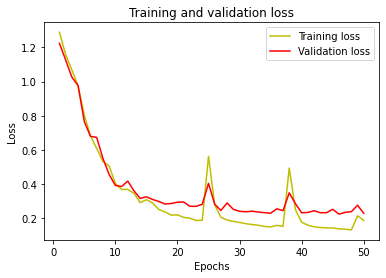

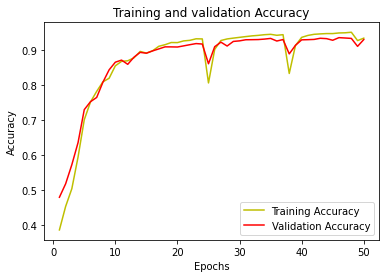

In [27]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

In [29]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)

<tf.Variable 'UnreadVariable' shape=(4, 4) dtype=float32, numpy=
array([[820896.,   2946.,  10843.,   4928.],
       [ 10770., 450715.,  19997.,   7824.],
       [ 12852.,  18337., 241619.,  10730.],
       [ 10024.,  17056.,   8996., 317547.]], dtype=float32)>

In [30]:
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8458712


In [31]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

[[820896.   2946.  10843.   4928.]
 [ 10770. 450715.  19997.   7824.]
 [ 12852.  18337. 241619.  10730.]
 [ 10024.  17056.   8996. 317547.]]


In [32]:
print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

IoU for class1 is:  0.94003725
IoU for class2 is:  0.8542012
IoU for class3 is:  0.7471813
IoU for class4 is:  0.8420652


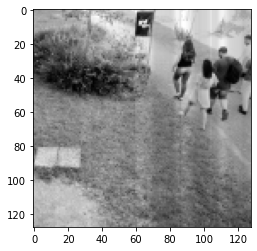

In [34]:
plt.imshow(train_images[0, :,:,0], cmap='gray')

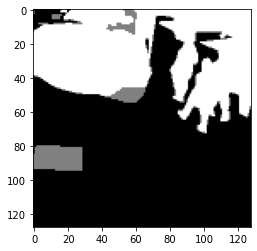

In [35]:
plt.imshow(train_masks[0], cmap='gray')

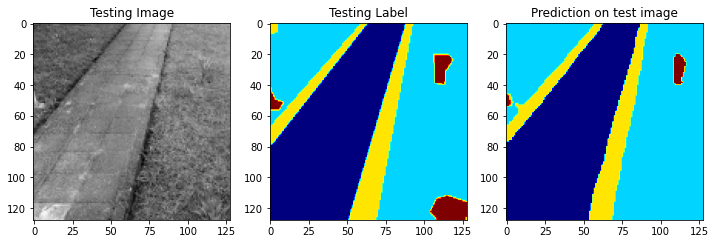

In [36]:
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()